In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import scipy.stats as stats
%matplotlib inline

from GDELT_utils import GDELT_columns, usecols, dtype_dict, \
                        state_dict, state_heat_map
        
data_2008 = "./200811.csv"
data_2016 = "./20161108.export.CSV"

df_2008 = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], 
                        usecols=usecols, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])
df_2016 = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, 
                        usecols=usecols, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])

In [2]:
df_2008_us = df_2008.loc[df_2008['ActionGeo_CountryCode'] == 'US',:].copy()
df_2016_us = df_2016.loc[df_2016['ActionGeo_CountryCode'] == 'US',:].copy()

election_day_2008 = np.datetime64('2008-11-04')
df_2008_usel = df_2008_us.loc[df_2008_us['SQLDATE'] == election_day_2008,:] \
                         .copy()
df_2008_usel['ActionGeo_ADM1Code'] = df_2008_usel['ActionGeo_ADM1Code'] \
                                     .cat.remove_unused_categories()
election_day_2016 = np.datetime64('2016-11-08')
df_2016_usel = df_2016_us.loc[df_2016_us['SQLDATE'] == election_day_2016,:] \
                         .copy()
df_2016_usel['ActionGeo_ADM1Code'] = df_2016_usel['ActionGeo_ADM1Code'] \
                                     .cat.remove_unused_categories()
    
df_2008_usel['ActionGeo_ADM1Code'] = df_2008_usel['ActionGeo_ADM1Code'] \
                                     .map(state_dict)
df_2016_usel['ActionGeo_ADM1Code'] = df_2016_usel['ActionGeo_ADM1Code'] \
                                     .map(state_dict)

# Introduction

The question we seek to answer in this report is whether the average tone of media coverage was significantly different on the USA presidential election days of 2008 and 2016. It is widely felt in anecdotal circles that there were qualitative differences between the tone of media coverage between 2008 and 2016. It would be valuable to make these feelings quantitative to demonstrate whether this was perception or reality. If it were so, then we could start to look under the surface to see what trends or changes led to this reality. If it were not so, we may be able to correct for any bias and look at the election of 2016 with more honesty. 

# Data

To approach this question analytically, we're going to use a sample of the dataset from the Global Data on Events, Location and Tone project, also known as GDELT. GDELT provides data on global events, storing such things as the type of the event, the actors involved, the location and the tone of documents that report on the event. It thus provides an abstract and data driven view of the world's affairs. It has been in operation since 2013, and has data available from January 1, 1979 to the present. 

We're going to take a look at the data available for the election days of 2008 and 2016: November 4th, 2008 and November 8th, 2016. Of the data GDELT provides, we will focus our analysis on the AvgTone column, which aggregates the average tone of documents talking about the event which has been recorded in the data. As discussed in the GDELT documentation, this can give an overall tone of the narrative that has developed around an event. 

# Methods

We will first produce some visualizations to gain insight into what the data might show. We then use a T-test between the AvgTone of documents in 2008 and 2016 to determine whether the difference is statistically significant. Our desired p-value < 0.05. We will explore this both on a overall level, as well as on a state level to see if we can narrow down any difference between states.

# Data Exploration

First, we'll look at the overall range of the values.

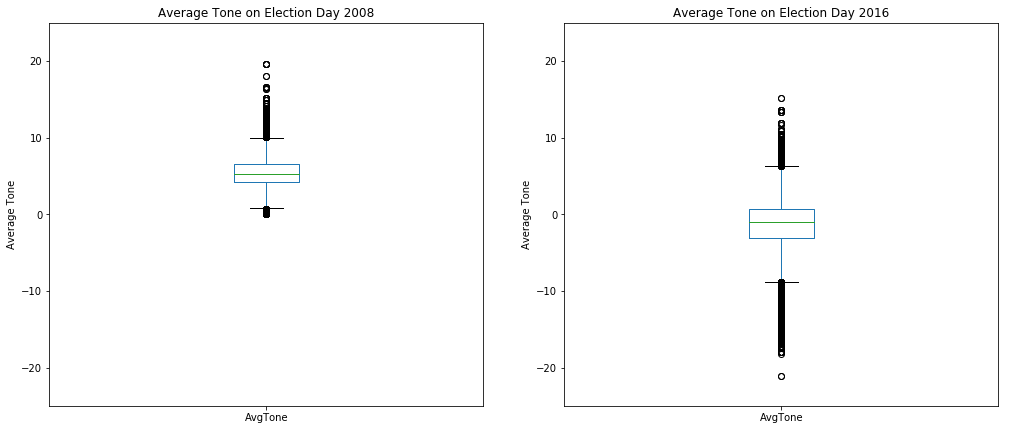

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.tight_layout(pad=5)

plt.subplot(1,2,1)
df_2008_usel['AvgTone'].plot(kind='box')
plt.ylim(-25, 25)
plt.ylabel("Average Tone")
plt.title("Average Tone on Election Day 2008")

plt.subplot(1,2,2)
df_2016_usel['AvgTone'].plot(kind='box')
plt.ylim(-25, 25)
plt.ylabel("Average Tone")
plt.title("Average Tone on Election Day 2016");

We already notice an apparent difference in the average tone undifferentiated by state. We next get an idea of what the data looks like on a state by state level, first as a point plot with confidence intervals and then heatmaps.

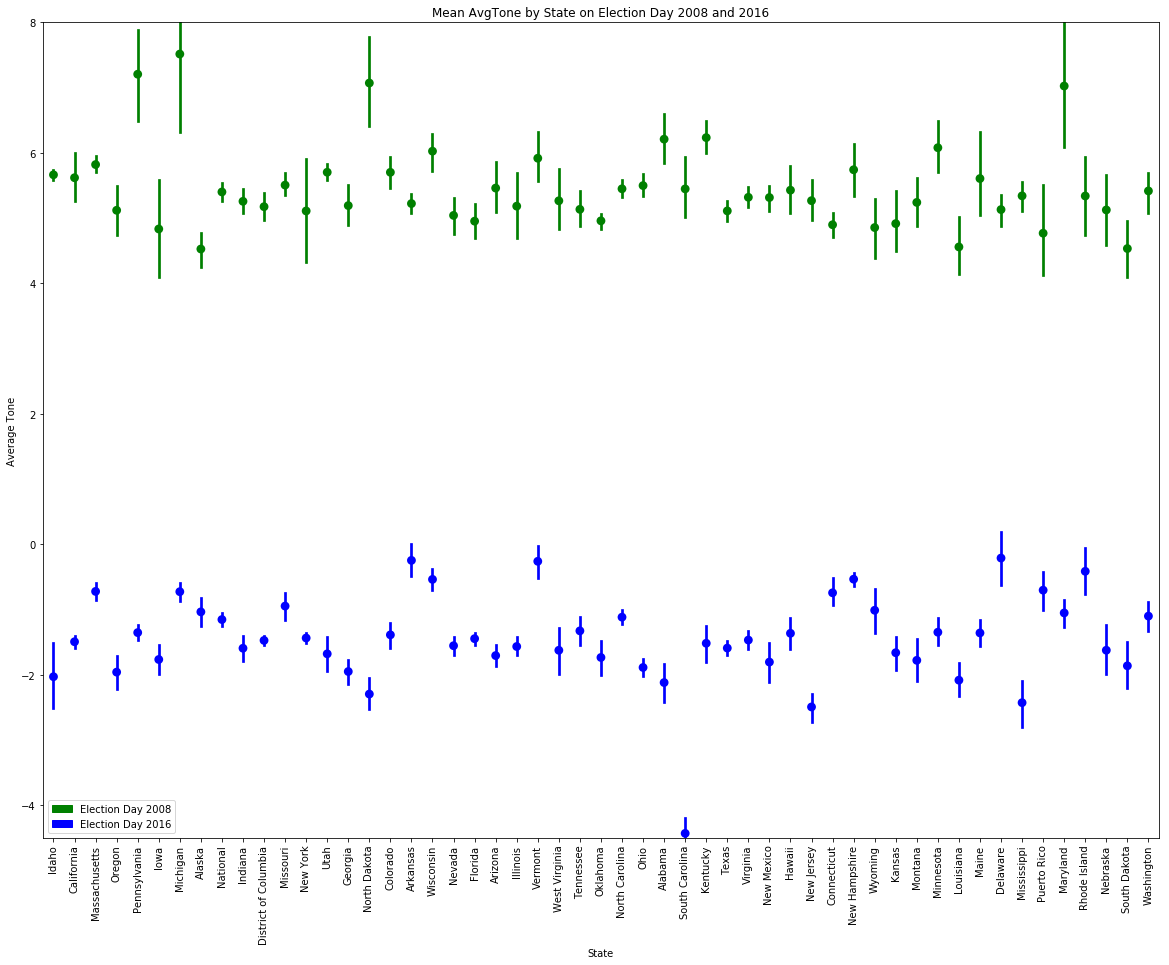

In [4]:
f, ax = plt.subplots(1, 1, figsize=(20,15))
h1 = sns.pointplot(ax=ax, x="ActionGeo_ADM1Code", y="AvgTone", 
                   color="green", label="2008",
                   data=df_2008_usel, join=False)
h2 = sns.pointplot(ax=ax, x="ActionGeo_ADM1Code", y="AvgTone", 
                   label="2016", color="blue", 
                   data=df_2016_usel, join=False)

green_patch = mpatches.Patch(color='green', 
                             label='Election Day 2008')
blue_patch = mpatches.Patch(color='blue', 
                            label='Election Day 2016')
plt.legend(handles=[green_patch,blue_patch])

plt.xticks(rotation=90);
plt.ylim(-4.5, 8)
plt.xlabel("State")
plt.ylabel("Average Tone")
plt.title("Mean AvgTone by State on Election Day 2008 and 2016");

In [5]:
avgtone_2008 = df_2008_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
            .mean()[np.sort(df_2008_usel['ActionGeo_ADM1Code'].unique())] \
            .rename(state_dict)
        
avgtone_2016 = df_2016_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
            .mean()[np.sort(df_2016_usel['ActionGeo_ADM1Code'].unique())] \
            .rename(state_dict)

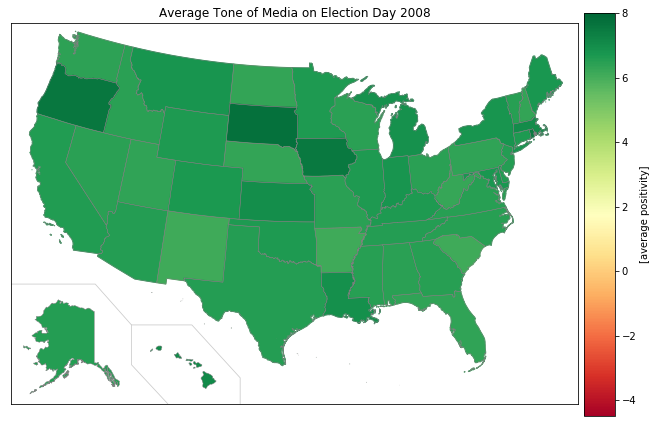

In [6]:
state_heat_map(avgtone_2008, -4.5, 8, 
               'Average Tone of Media on Election Day 2008');

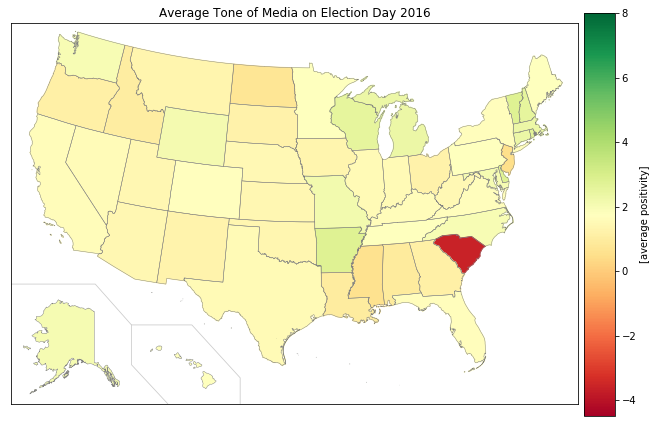

In [7]:
state_heat_map(avgtone_2016, -4.5, 8, 
               'Average Tone of Media on Election Day 2016');

Again, we see what looks like a fairly clear difference between the two election days in tone. Let's now perform our statistical tests.

# Hypothesis Test

We first perform the overall t-test. Our null hypothesis is that there is no difference between the media tone of the election day on 2008 and 2016.

In [8]:
stats.ttest_ind(df_2008_usel['AvgTone'], 
                df_2016_usel['AvgTone'])

Ttest_indResult(statistic=223.70611781321745, pvalue=0.0)

And end up with a vanishingly small pvalue. Thus we're almost absolutely certain that the difference is statistically significant. We'll look at it on a state level as well to see if it fails on any particular state. As we're looking at 50 states plus DC plus Puerto Rico plus a generic National level, we'll apply a Bonferroni correction to our desired p-value. Thus our p-value will be 0.05/53 which is .00094.

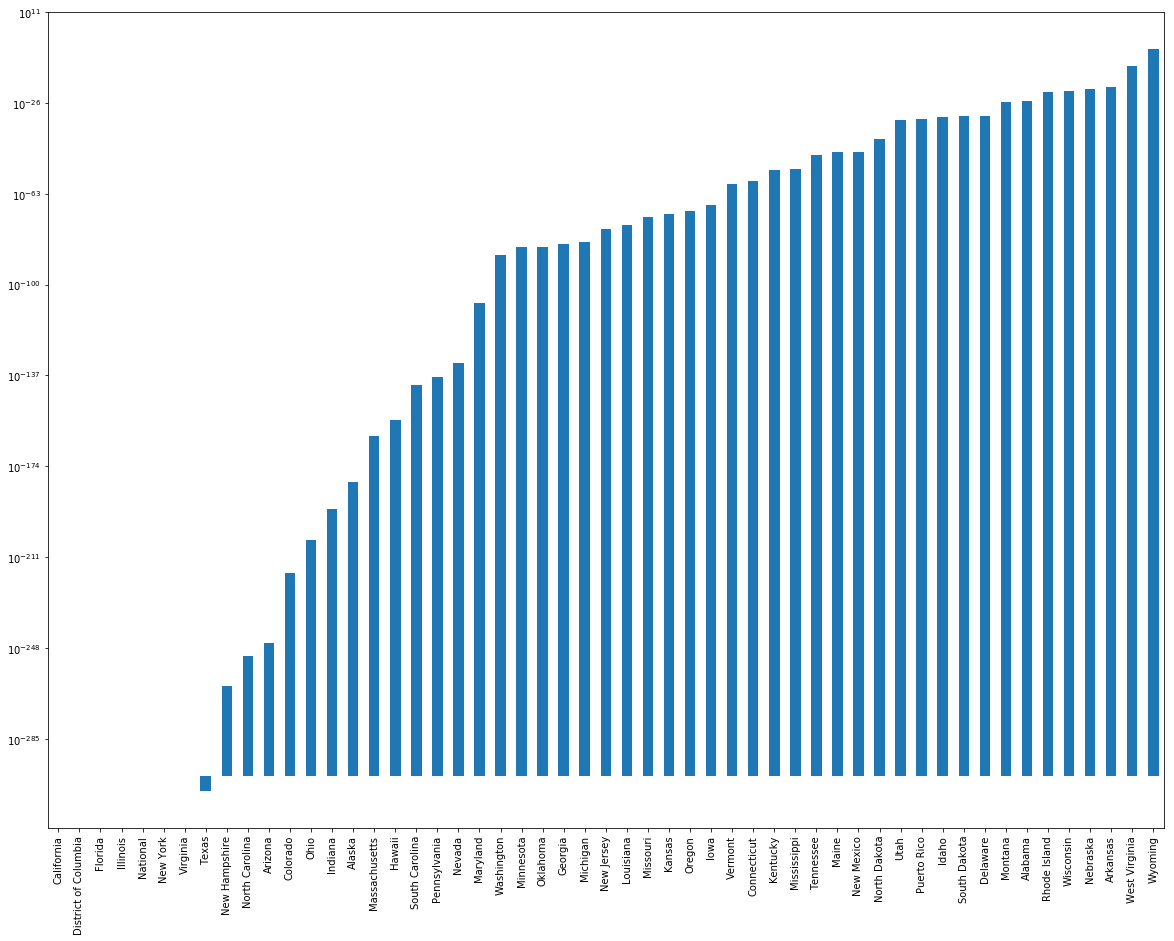

In [9]:
state_ttests = []
for state in state_dict.values():
    state_df_2008 = \
            df_2008_usel[df_2008_usel['ActionGeo_ADM1Code'] == state]
    state_df_2016 = \
            df_2016_usel[df_2016_usel['ActionGeo_ADM1Code'] == state]
    state_ttest = stats.ttest_ind(state_df_2008['AvgTone'],
                                  state_df_2016['AvgTone'])
    state_ttests.append((state, state_ttest.pvalue))

state_ttests = sorted(state_ttests, key=lambda x:x[1])
state_ttests = pd.Series(map(lambda x:x[1], state_ttests), 
                         index=map(lambda x:x[0], state_ttests))

In [10]:
(state_ttests < .00094).all()

True

And in fact, all of the state wise differences also pass this adjusted p value. It is very clear from the data that there is a statistically significant difference between the media tone in 2008 and 2016.

# Appendix: Individual State P Values

In [11]:
state_ttests

California               0.000000e+00
District of Columbia     0.000000e+00
Florida                  0.000000e+00
Illinois                 0.000000e+00
National                 0.000000e+00
New York                 0.000000e+00
Virginia                 0.000000e+00
Texas                   6.932284e-307
New Hampshire           3.915434e-264
North Carolina          4.222102e-252
Arizona                 6.868141e-247
Colorado                2.505536e-218
Ohio                    1.079803e-204
Indiana                 2.566805e-192
Alaska                  2.565068e-181
Massachusetts           2.719951e-162
Hawaii                  9.993425e-156
South Carolina          1.036064e-141
Pennsylvania            1.896818e-138
Nevada                  1.271458e-132
Maryland                5.173024e-108
Washington               1.374915e-88
Minnesota                1.849742e-85
Oklahoma                 2.437715e-85
Georgia                  5.401255e-84
Michigan                 2.474716e-83
New Jersey  